This is an adaptation of the [Holt-Winters with Python](https://docs.timescale.com/latest/tutorials/tutorial-forecasting#tutorial-python) example for TimescaleDB using the [Prometheus SQL adapter](https://github.com/ssube/prometheus-sql-adapter) schema as a data source.

In [2]:
import matplotlib.pyplot as plot
import numpy as np
import os
import pandas as pd
import pandas.io.json as pj
import psycopg2
from statsmodels.tsa.api import ExponentialSmoothing

In [3]:
conn = psycopg2.connect(os.environ.get('PROMSQL_CONNSTR'))
samples = pd.read_sql_query("""
SELECT 
    s.bucket AS time, 
    MAX(s.max_load) AS value, 
    REGEXP_REPLACE(l.labels->>'instance', '\d+\.\d+\.\d+\.', 'xxx.yyy.zzz.') AS instance 
FROM agg_instance_load AS s
JOIN metric_labels AS l 
    ON s.lid = l.lid
WHERE s.bucket > NOW() - INTERVAL '14 days'
GROUP BY s.bucket, l.labels->>'instance'
""", conn)
conn.close()

In [4]:
print(samples.head(5))

                 time  value              instance
0 2019-12-19 13:45:00  15.17   xxx.yyy.zzz.59:9100
1 2019-12-21 05:55:00   1.54  xxx.yyy.zzz.163:9100
2 2019-12-12 20:45:00   1.47  xxx.yyy.zzz.158:9100
3 2019-12-15 22:50:00   0.66   xxx.yyy.zzz.59:9100
4 2019-12-14 16:35:00   0.56  xxx.yyy.zzz.164:9100


In [5]:
nodes = samples[['instance']].replace(r':\d+', '', regex=True)
load = samples.drop(columns=['instance']).join(nodes)

In [6]:
print(load.head(15))

                  time  value         instance
0  2019-12-19 13:45:00  15.17   xxx.yyy.zzz.59
1  2019-12-21 05:55:00   1.54  xxx.yyy.zzz.163
2  2019-12-12 20:45:00   1.47  xxx.yyy.zzz.158
3  2019-12-15 22:50:00   0.66   xxx.yyy.zzz.59
4  2019-12-14 16:35:00   0.56  xxx.yyy.zzz.164
5  2019-12-10 23:15:00   0.60  xxx.yyy.zzz.164
6  2019-12-19 05:40:00   0.86  xxx.yyy.zzz.192
7  2019-12-13 11:15:00   1.47   xxx.yyy.zzz.99
8  2019-12-12 10:05:00   0.38   xxx.yyy.zzz.77
9  2019-12-10 15:20:00   1.19   xxx.yyy.zzz.77
10 2019-12-16 04:20:00   1.02  xxx.yyy.zzz.180
11 2019-12-12 10:30:00   1.81  xxx.yyy.zzz.163
12 2019-12-15 20:55:00   0.67   xxx.yyy.zzz.99
13 2019-12-19 03:05:00   0.94  xxx.yyy.zzz.236
14 2019-12-21 18:45:00   0.39  xxx.yyy.zzz.158


In [7]:
iload = load.groupby(['instance'])
print(iload.describe())

                  value                                                   
                  count      mean       std   min   25%   50%   75%    max
instance                                                                  
xxx.yyy.zzz.158  3581.0  0.677825  0.518885  0.02  0.30  0.57  0.95   7.97
xxx.yyy.zzz.163  3581.0  1.660980  0.617139  0.31  1.21  1.60  2.02   4.41
xxx.yyy.zzz.164  3582.0  0.760659  0.413186  0.01  0.46  0.67  0.95   2.85
xxx.yyy.zzz.180  3581.0  1.004636  0.895787  0.09  0.48  0.78  1.19  10.00
xxx.yyy.zzz.192  3581.0  0.828068  0.412223  0.10  0.51  0.76  1.09   2.80
xxx.yyy.zzz.236  3582.0  0.543465  0.263489  0.09  0.36  0.47  0.66   2.53
xxx.yyy.zzz.59   3581.0  0.974457  1.542583  0.05  0.35  0.56  0.94  16.53
xxx.yyy.zzz.77   3581.0  0.791617  0.496911  0.06  0.45  0.72  1.03   7.34
xxx.yyy.zzz.99   3582.0  0.853286  0.432077  0.09  0.55  0.75  1.04   3.11


In [8]:
tload = pd.pivot(load, index='time', columns='instance', values='value').resample('1h').max()
print(tload.head(2))

instance             xxx.yyy.zzz.158  xxx.yyy.zzz.163  xxx.yyy.zzz.164  \
time                                                                     
2019-12-10 12:00:00             1.65             3.58             1.75   
2019-12-10 13:00:00             1.37             3.53             1.48   

instance             xxx.yyy.zzz.180  xxx.yyy.zzz.192  xxx.yyy.zzz.236  \
time                                                                     
2019-12-10 12:00:00             1.19             0.89             1.29   
2019-12-10 13:00:00             1.28             2.12             1.02   

instance             xxx.yyy.zzz.59  xxx.yyy.zzz.77  xxx.yyy.zzz.99  
time                                                                 
2019-12-10 12:00:00            0.61            0.81            2.40  
2019-12-10 13:00:00            1.15            1.31            2.14  


Fitting trends for xxx.yyy.zzz.158... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 hours; 28 hours; 32 hours; 36 hours; 40 hours; 44 hours; 48 hours; 
Plotting xxx.yyy.zzz.158
Fitting trends for xxx.yyy.zzz.163... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 hours; 28 hours; 32 hours; 36 hours; 40 hours; 44 hours; 48 hours; 
Plotting xxx.yyy.zzz.163
Fitting trends for xxx.yyy.zzz.164... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 hours; 28 hours; 32 hours; 36 hours; 40 hours; 44 hours; 48 hours; 
Plotting xxx.yyy.zzz.164
Fitting trends for xxx.yyy.zzz.180... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 hours; 28 hours; 32 hours; 36 hours; 40 hours; 44 hours; 48 hours; 
Plotting xxx.yyy.zzz.180
Fitting trends for xxx.yyy.zzz.192... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 hours; 28 hours; 32 hours; 36 hours; 40 hours; 44 hours; 48 hours; 
Plotting xxx.yyy.zzz.192
Fitting trends for xxx.yyy.zzz.236... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 h

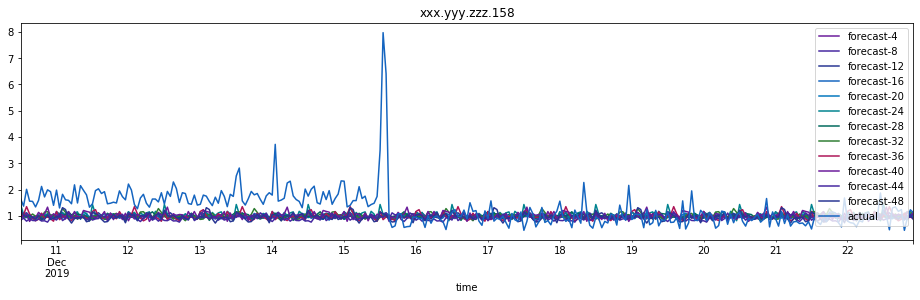

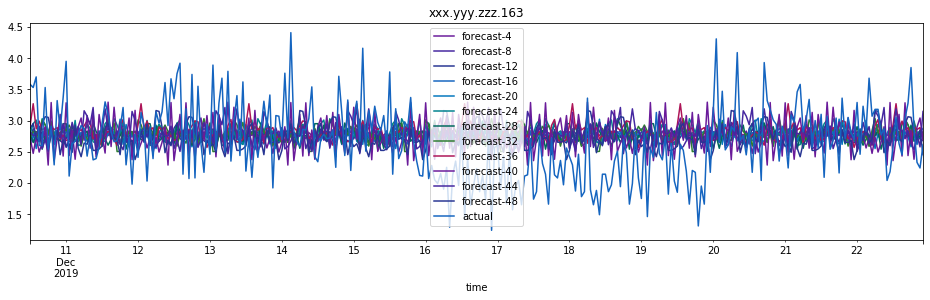

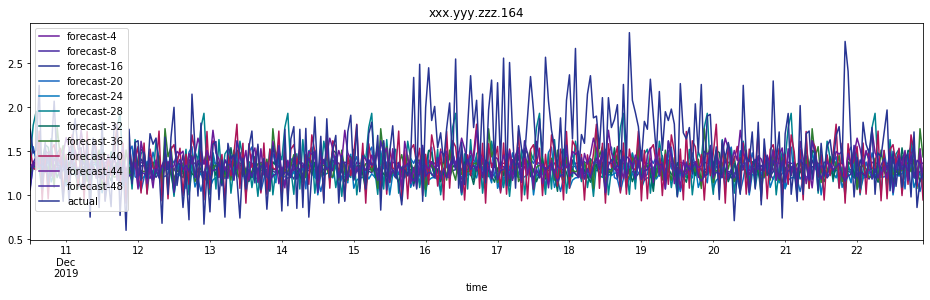

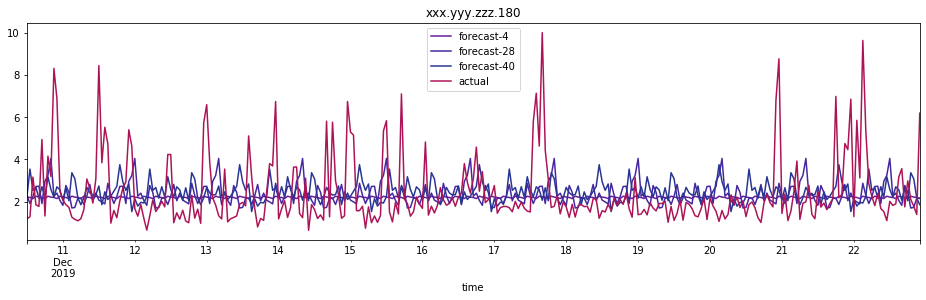

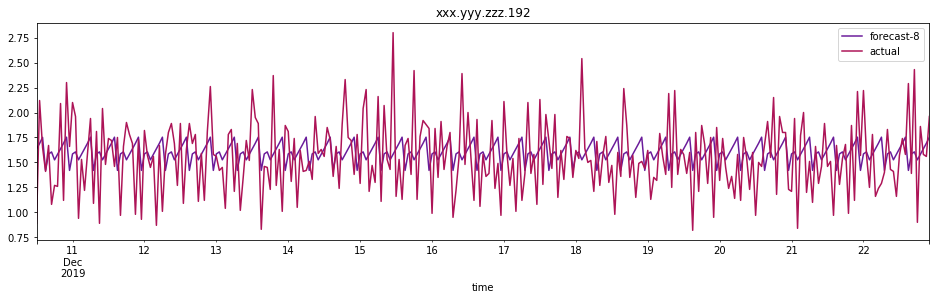

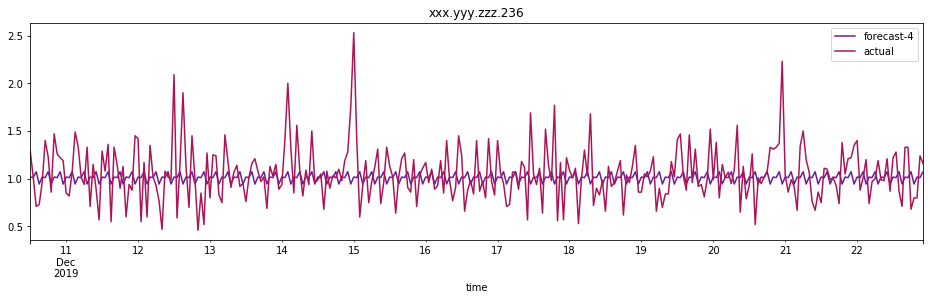

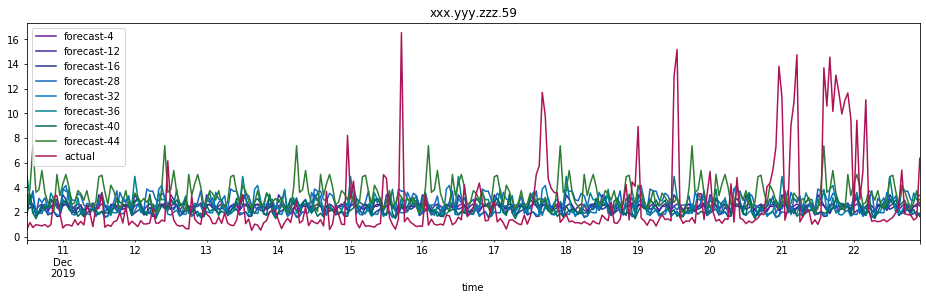

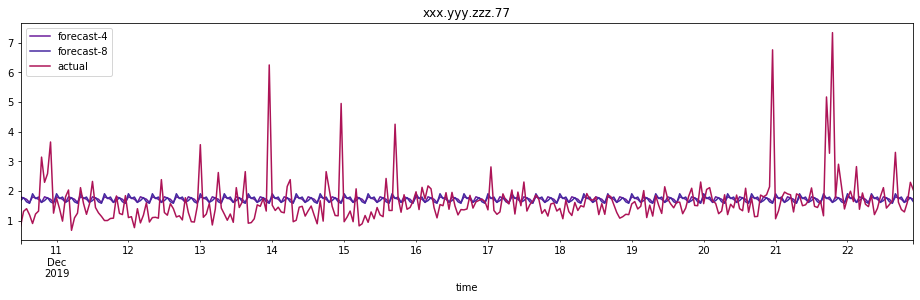

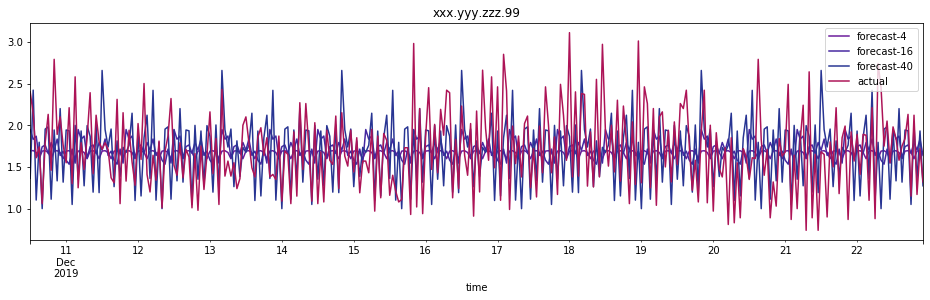

In [12]:
%matplotlib inline

palette_fit = [
    '#6a1b9a', '#4527a0', '#283593', '#1565c0',
    '#0277bd', '#00838f', '#00695c', '#2e7d32'
]
palette_key = '#ad1457'

period_hour = 4
period_num = 12

tf = pd.DataFrame(data=tload, copy=True)
for row in tf:
    fload = tf[row]
    vals = np.array(fload.to_numpy(np.float64).flat)
    
    print(f'Fitting trends for {fload.name}...', end=' ')
    fss = []
    for period in np.linspace(period_hour, period_hour * period_num, period_num):
        try:
            ip = int(period)
            print(f'{ip} hours;', end=' ')
            fit = ExponentialSmoothing(
                vals, trend='add', seasonal='add', seasonal_periods=ip, damped=True
            ).fit(use_boxcox=True)
            forecast = fit.forecast(len(fload))
            
            if not np.isnan(forecast[0]):
                fs = pd.Series(forecast, name=f'forecast-{ip}', index=fload.index)
                fss.append(fs)
        except:
            print(f'error fitting {row} at {period} hour period')
    
    print()
    print(f'Plotting {fload.name}')
    
    colors = palette_fit[0:len(fss)]
    colors.append(palette_key)
    
    overall = pd.concat([*fss, fload], axis=1).rename(columns={fload.name: "actual"})    
    overall.plot.line(title=fload.name, color=colors, figsize=(16, 4))